In [1]:
import sys
sys.version

'3.6.8 (default, Jan 14 2019, 11:02:34) \n[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]'

In [4]:
!pip install seaborn
!pip install haversine
!pip install pyarrow

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import math
import numbers

from haversine import haversine
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
pd.set_option('display.max_columns', None)

plt.rcParams['font.family'] = 'Nanum Gothic'
sns.set(font="NanumGothic")

In [10]:
import os
os.chdir("/project/work/Passenger_Demand")

In [13]:
%%time
mybicard_401 = pd.read_parquet('model_mr/mybicard_401.parquet', engine='pyarrow')

CPU times: user 1.85 s, sys: 1.07 s, total: 2.91 s
Wall time: 1.3 s


In [14]:
# 경주시, 양산시, 울산광역시, 부산광역시
bus_stop = pd.read_csv("data/울산광역시_버스 정류소 위치 정보_20200531.csv", encoding = "euc-kr")
bus_stop = bus_stop.loc[bus_stop["권역"] == "울산광역시"]
bus_stop.columns = ["stop_nm", "stop_id", "longitude", "latitude", "city"]

In [15]:
bus_stop.head(3)

,stop_nm,stop_id,longitude,latitude,city
102,중앙여고,11101,129.343599,35.553219,울산광역시
103,중앙여고,11102,129.343621,35.553309,울산광역시
104,강변이편한세상,11104,129.347783,35.554441,울산광역시


In [16]:
#마이비데이터 정류장번호를 실제 정류장번호와 매핑(by 박세호선임)
bus_stop_401_1 = pd.read_csv("data/401_율리_꽃바위.csv", encoding = "euc_kr")
bus_stop_401_1['direction'] = '1'
bus_stop_401_2 = pd.read_csv("data/401_꽃바위_율리.csv", encoding = "euc_kr")
bus_stop_401_2['direction'] = '2'
bus_stop_401 = pd.concat([bus_stop_401_1, bus_stop_401_2])
bus_stop_401.columns = ["mybi_stop_id", "stop_id", 'direction']

In [17]:
bus_stop_401.head(3)

,mybi_stop_id,stop_id,direction
0,3100597,30504,1
1,3100339,30714,1
2,3101462,30712,1


In [18]:
bus_stop_ulsan = pd.merge(bus_stop_401, bus_stop[["stop_id", "longitude", "latitude", "stop_nm"]], on = "stop_id", how = "inner")

In [19]:
bus_stop_ulsan.shape

(131, 6)

In [20]:
bus_stop_ulsan.head(3)

,mybi_stop_id,stop_id,direction,longitude,latitude,stop_nm
0,3100597,30504,1,129.246863,35.529520,율리공영차고지
1,3100339,30714,1,129.255322,35.537435,우신고등학교입구
2,3101462,30712,1,129.257440,35.539800,울산과학대학앞


In [21]:
def calDist(data1, data2):
    point1 = (data1['latitude'], data1['longitude'])
    point2 = (data2['위도'], data2['경도'])
        
    if point1[0] is None or point1[1] is None or point2[0] is None or point2[1] is None:
        return None
    if math.isnan(point1[0]) | math.isnan(point1[1]) | math.isnan(point2[0]) | math.isnan(point2[1]):
        return None
    assert isinstance(point1[0], numbers.Number) and -90<=point1[0] and point1[0]<=90
    assert isinstance(point1[1], numbers.Number) and -180<=point1[1] and point1[1]<=180
    assert isinstance(point2[0], numbers.Number) and -90<=point2[0] and point2[0]<=90
    assert isinstance(point2[1], numbers.Number) and -180<=point2[1] and point2[1]<=180
    
    dist_between = haversine(point1, point2, unit = 'm')
    return round(dist_between, 0)

In [22]:
def getAvgDist(num1, num2):
    if math.isnan(num1):
        avg_dist = num2
    elif math.isnan(num2):
        avg_dist = num1
    elif num1 >= num2:
        avg_dist = num2
    else :
        avg_dist = num1
    return avg_dist

In [23]:
bus_stop_ulsan_1 = bus_stop_ulsan[bus_stop_ulsan['direction']=='1'].copy()
bus_stop_ulsan_1['경도'], bus_stop_ulsan_1['위도'] = bus_stop_ulsan_1.shift(1)['longitude'], bus_stop_ulsan_1.shift(1)['latitude']
bus_stop_ulsan_1['dist1'] = bus_stop_ulsan_1.apply(lambda x: calDist(x, x), 1)
bus_stop_ulsan_1['경도'], bus_stop_ulsan_1['위도'] = bus_stop_ulsan_1.shift(-1)['longitude'], bus_stop_ulsan_1.shift(-1)['latitude']
bus_stop_ulsan_1['dist2'] = bus_stop_ulsan_1.apply(lambda x: calDist(x, x), 1)
bus_stop_ulsan_1['dist'] = bus_stop_ulsan_1.apply(lambda x: getAvgDist(x['dist1'], x['dist2']), 1)
bus_stop_ulsan_1

,mybi_stop_id,stop_id,direction,longitude,latitude,stop_nm,경도,위도,dist1,dist2,dist
0,3100597,30504,1,129.246863,35.529520,율리공영차고지,129.255322,35.537435,NaN,1166.0,1166.0
1,3100339,30714,1,129.255322,35.537435,우신고등학교입구,129.257440,35.539800,1166.0,325.0,325.0
2,3101462,30712,1,129.257440,35.539800,울산과학대학앞,129.260306,35.543755,325.0,511.0,325.0
3,3101461,30708,1,129.260306,35.543755,울산대학교앞,129.261981,35.546813,511.0,372.0,372.0
4,3100479,30706,1,129.261981,35.546813,울산대학교후문,129.263036,35.548831,372.0,244.0,244.0
5,3101460,30704,1,129.263036,35.548831,신복로터리,129.263912,35.545871,244.0,339.0,244.0
6,3101459,22401,1,129.263912,35.545871,옥현주공아파트앞,129.264386,35.541685,339.0,467.0,339.0
7,3101458,22403,1,129.264386,35.541685,성광여고앞,129.279146,35.537109,467.0,1429.0,467.0
8,3101457,40601,1,129.279146,35.537109,공원묘지입구,129.283144,35.536061,1429.0,380.0,380.0
9,3100176,40604,1,129.283144,35.536061,옥동중학교앞,129.288882,35.535148,380.0,529.0,380.0


In [24]:
bus_stop_ulsan_2 = bus_stop_ulsan[bus_stop_ulsan['direction']=='2'].copy()
bus_stop_ulsan_2['경도'], bus_stop_ulsan_2['위도'] = bus_stop_ulsan_2.shift(1)['longitude'], bus_stop_ulsan_2.shift(1)['latitude']
bus_stop_ulsan_2['dist1'] = bus_stop_ulsan_2.apply(lambda x: calDist(x, x), 1)
bus_stop_ulsan_2['경도'], bus_stop_ulsan_2['위도'] = bus_stop_ulsan_2.shift(-1)['longitude'], bus_stop_ulsan_2.shift(-1)['latitude']
bus_stop_ulsan_2['dist2'] = bus_stop_ulsan_2.apply(lambda x: calDist(x, x), 1)
bus_stop_ulsan_2['dist'] = bus_stop_ulsan_2.apply(lambda x: getAvgDist(x['dist1'], x['dist2']), 1)
bus_stop_ulsan_2

,mybi_stop_id,stop_id,direction,longitude,latitude,stop_nm,경도,위도,dist1,dist2,dist
64,3100440,19014,2,129.409749,35.478117,꽃바위,129.412074,35.477899,NaN,212.0,212.0
65,3101560,25001,2,129.412074,35.477899,화암,129.415841,35.481411,212.0,518.0,212.0
66,3101559,25003,2,129.415841,35.481411,현대비치타운,129.418852,35.483501,518.0,358.0,358.0
67,3101558,25005,2,129.418852,35.483501,우성현대아파트,129.422853,35.485310,358.0,414.0,358.0
68,3100413,25011,2,129.422853,35.485310,해피랜드아파트앞,129.424330,35.485841,414.0,146.0,146.0
69,3100086,25007,2,129.424330,35.485841,방어동 행정복지센터,129.425855,35.487869,146.0,264.0,146.0
70,3100433,25009,2,129.425855,35.487869,방어진초등학교,129.426408,35.491537,264.0,411.0,264.0
71,3101432,24236,2,129.426408,35.491537,대왕암공원입구,129.428013,35.497744,411.0,705.0,411.0
72,3101431,24234,2,129.428013,35.497744,일산해수욕장,129.428968,35.501499,705.0,426.0,426.0
73,3101430,24232,2,129.428968,35.501499,번덕마을,129.429779,35.505181,426.0,416.0,416.0


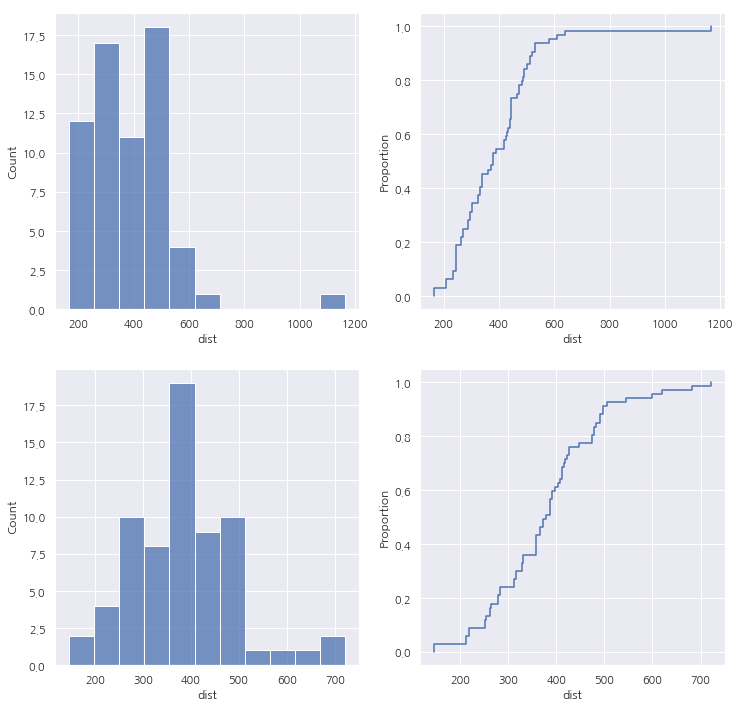

In [25]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2,2,1)
sns.histplot(bus_stop_ulsan_1['dist'], ax=ax1)
ax2 = fig.add_subplot(2,2,2)
sns.ecdfplot(bus_stop_ulsan_1['dist'], ax=ax2)
ax3 = fig.add_subplot(2,2,3)
sns.histplot(bus_stop_ulsan_2['dist'], ax=ax3)
ax4 = fig.add_subplot(2,2,4)
sns.ecdfplot(bus_stop_ulsan_2['dist'], ax=ax4)

In [26]:
bus_stop_ulsan_1.describe()

,mybi_stop_id,stop_id,longitude,latitude,경도,위도,dist1,dist2,dist
count,6.400000e+01,64.000000,64.000000,64.000000,63.000000,63.000000,63.000000,63.000000,64.000000
mean,3.101221e+06,31026.968750,129.362940,35.529956,129.364783,35.529963,485.539683,485.539683,387.515625
std,5.720115e+02,7008.917064,0.060508,0.021229,0.059157,0.021399,228.851327,228.851327,149.773691
min,3.100057e+06,19016.000000,129.246863,35.477671,129.255322,35.477671,165.000000,165.000000,165.000000
25%,3.101193e+06,24228.500000,129.315362,35.524796,129.318415,35.524686,366.000000,366.000000,283.000000
50%,3.101454e+06,30618.000000,129.377473,35.535213,129.379093,35.535279,444.000000,444.000000,380.000000
75%,3.101483e+06,40404.000000,129.420185,35.540175,129.421187,35.540551,530.000000,530.000000,468.000000
max,3.102806e+06,40613.000000,129.432980,35.561309,129.432980,35.561309,1429.000000,1429.000000,1166.000000


In [27]:
marketplace = pd.read_csv('data/울산광역시_상권정보_201231.csv')

In [28]:
marketplace.shape

(52188, 39)

In [29]:
marketplace.head(3)

,상가업소번호,상호명,지점명,상권업종대분류코드,상권업종대분류명,상권업종중분류코드,상권업종중분류명,상권업종소분류코드,상권업종소분류명,표준산업분류코드,표준산업분류명,시도코드,시도명,시군구코드,시군구명,행정동코드,행정동명,법정동코드,법정동명,지번코드,대지구분코드,대지구분명,지번본번지,지번부번지,지번주소,도로명코드,도로명,건물본번지,건물부번지,건물관리번호,건물명,도로명주소,구우편번호,신우편번호,동정보,층정보,호정보,경도,위도
0,20736666,삼산프리미어어학원,NaN,R,학문/교육,R04,학원-어학,R04A01,학원-외국어/어학,P85502,외국어학원,31,울산광역시,31140,남구,3114057000,삼산동,3.114011e+09,삼산동,3.114010e+18,1,대지,1546,3.0,울산광역시 남구 삼산동 1546-3,3.114030e+11,울산광역시 남구 돋질로,286,NaN,3.114010e+24,NaN,울산광역시 남구 돋질로 286,680816,44705,NaN,NaN,NaN,129.336091,35.544065
1,24090929,왕생이입시단과학원,NaN,R,학문/교육,R01,학원-보습교습입시,R01A01,학원-입시,P85501,일반 교과 학원,31,울산광역시,31140,남구,3114055000,신정5동,3.114010e+09,신정동,3.114010e+18,1,대지,80,19.0,울산광역시 남구 신정동 80-19,3.114040e+11,울산광역시 남구 월평로147번길,5,NaN,3.114010e+24,NaN,울산광역시 남구 월평로147번길 5,680010,44685,NaN,NaN,NaN,129.320966,35.545070
2,21683173,이벤트기획연,NaN,F,생활서비스,F20,행사/이벤트,F20A02,이벤트기획,N75992,전시 및 행사 대행업,31,울산광역시,31140,남구,3114055000,신정5동,3.114010e+09,신정동,3.114060e+18,1,대지,236,107.0,울산광역시 남구 신정동 236-107,3.114030e+11,울산광역시 남구 월평로,141,NaN,3.114010e+24,NaN,울산광역시 남구 월평로 141,680010,44685,NaN,NaN,NaN,129.320748,35.544531


In [30]:
list(marketplace['상권업종중분류명'].unique())

['학원-어학',
 '학원-보습교습입시',
 '행사/이벤트',
 '한식',
 '학문교육기타',
 '의약/의료품소매',
 '종합소매점',
 '기타음식업',
 '유흥주점',
 '커피점/카페',
 '음/식료품소매',
 '이/미용/건강',
 '자동차/자동차용품',
 '가방/신발/액세서리',
 '호텔/콘도',
 '운동/경기용품소매',
 '유아교육',
 '화장품소매',
 '모텔/여관/여인숙',
 '학원-음악미술무용',
 '학원기타',
 '선물/팬시/기념품',
 '부동산중개',
 '닭/오리요리',
 '가정/주방/인테리어',
 '일식/수산물',
 'PC/오락/당구/볼링등',
 '제과제빵떡케익',
 '의복의류',
 '책/서적/도서',
 '중식',
 '건강/미용식품',
 '자동차/이륜차',
 '기타판매업',
 '분식',
 '사진/광학/정밀기기소매',
 '주유소/충전소',
 '세탁/가사서비스',
 '별식/퓨전요리',
 '가전제품소매',
 '양식',
 '민박/하숙',
 '인력/고용/용역알선',
 '철물/난방/건설자재소매',
 '페인트/유리제품소매',
 '무도/유흥/가무',
 '시계/귀금속소매',
 '주택수리',
 '가구소매',
 '장례/묘지',
 '도서관/독서실',
 '물품기기대여',
 '사무/문구/컴퓨터',
 '학원-예능취미체육',
 '캠프/별장/펜션',
 '학원-자격/국가고시',
 '중고품소매/교환',
 '개인서비스',
 '운송/배달/택배',
 '기타서비스업',
 '패스트푸드',
 '요가/단전/마사지',
 '경마/경륜/성인오락',
 '취미/오락관련소매',
 '대중목욕탕/휴게',
 '예식/의례/관혼상제',
 '분양',
 '애견/애완/동물',
 '광고/인쇄',
 '개인/가정용품수리',
 '유아용품',
 '사진',
 '학원-컴퓨터',
 '부페',
 '학원-창업취업취미',
 '연극/영화/극장',
 '대행업',
 '실내운동시설',
 '예술품/골동품/수석/분재',
 '놀이/여가/취미',
 '스포츠/운동',
 '법무세무회계',
 '음식배달서비스',
 '운영관리시설',
 '종교용품판매',
 

In [31]:
bus_stop_ulsan.shape

(131, 6)

In [32]:
marketplace.shape

(52188, 39)

In [34]:
!pip install multiprocessing_on_dill

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 53 kB 828 kB/s eta 0:00:011
     |████████████████████████████████| 81 kB 1.3 MB/s eta 0:00:011
  Created wheel for multiprocessing-on-dill: filename=multiprocessing_on_dill-3.5.0a4-py3-none-any.whl size=64300 sha256=19df9bdde45a6b93d8ee62514484ea668c618a6e7ee8fb9a67662d802a8ac752
  Stored in directory: /home/ds_user1/.cache/pip/wheels/32/b0/ef/6c2022bef2a70b926ac63be4cbb721e55371492b6c72421bc1
Successfully built multiprocessing-on-dill


In [35]:
from multiprocessing_on_dill import Pool, cpu_count
from functools import partial
import pandas as pd
import numpy as np

def parallelize_dataframe(df, 
                          func, 
                          group_keys = None, 
                          num_cores = None,
                          **params):
    """
        Pandas DataFrame의 apply함수를 병렬처리 하는 함수

        Args: 
            df: 적용 대상 데이터프레임 (Pandas.DataFrame)
            group_keys: apply를 적용할 때 기준이되는 group by key

        Returns:
            df: (Pandas.DataFrame)
            
        Exception: 
    """

    if num_cores is None:
        num_cores = cpu_count()

    if group_keys is None:
        df_list = np.array_split(df, num_cores)
    elif group_keys is not None:
        gr_df = df.groupby(group_keys)
        df_list = [group for name, group in gr_df]
    
#     func = partial(func, **params)
    
    def map_func(data):
        return data.apply(func, axis = 1, **params)
        
        
    with Pool(num_cores) as p:

        pd_result = pd.concat(p.map(map_func, df_list))
#         pd_result = p.starmap(func, **params)
        
    return pd_result

In [36]:
bus_stop_ulsan.head(3)

,mybi_stop_id,stop_id,direction,longitude,latitude,stop_nm
0,3100597,30504,1,129.246863,35.529520,율리공영차고지
1,3100339,30714,1,129.255322,35.537435,우신고등학교입구
2,3101462,30712,1,129.257440,35.539800,울산과학대학앞


In [37]:
def countNearMarket(bus_stop, marketDf, category_list = None):
    data_copy = bus_stop.copy()
    if category_list == None:
        category_list = list(marketDf['상권업종중분류명'].unique())
        
    dist_list = marketDf.apply(lambda x: calDist(bus_stop, x), 1)
    within_data = marketDf.loc[dist_list <= (bus_stop['dist'] // 50) * 50 / 2]
    
    for i, ctgr in enumerate(category_list):
        data_copy[f"market_lv2_{i}"] = (within_data["상권업종중분류명"] == ctgr).sum()

    return data_copy

In [38]:
bus_stop_ulsan_all = pd.concat([bus_stop_ulsan_1, bus_stop_ulsan_2])

In [39]:
bus_stop_ulsan_all = bus_stop_ulsan_all[['mybi_stop_id', 'stop_id', 'direction', 'longitude', 'latitude', 'stop_nm', 'dist']]

In [40]:
%%time
bus_stop_401_store = parallelize_dataframe(df = bus_stop_ulsan_all, func = countNearMarket, num_cores = 10, marketDf = marketplace)

CPU times: user 16.9 s, sys: 630 ms, total: 17.5 s
Wall time: 1min 50s


In [41]:
bus_stop_401_store.head(3)

,mybi_stop_id,stop_id,direction,longitude,latitude,stop_nm,dist,market_lv2_0,market_lv2_1,market_lv2_2,market_lv2_3,market_lv2_4,market_lv2_5,market_lv2_6,market_lv2_7,market_lv2_8,market_lv2_9,market_lv2_10,market_lv2_11,market_lv2_12,market_lv2_13,market_lv2_14,market_lv2_15,market_lv2_16,market_lv2_17,market_lv2_18,market_lv2_19,market_lv2_20,market_lv2_21,market_lv2_22,market_lv2_23,market_lv2_24,market_lv2_25,market_lv2_26,market_lv2_27,market_lv2_28,market_lv2_29,market_lv2_30,market_lv2_31,market_lv2_32,market_lv2_33,market_lv2_34,market_lv2_35,market_lv2_36,market_lv2_37,market_lv2_38,market_lv2_39,market_lv2_40,market_lv2_41,market_lv2_42,market_lv2_43,market_lv2_44,market_lv2_45,market_lv2_46,market_lv2_47,market_lv2_48,market_lv2_49,market_lv2_50,market_lv2_51,market_lv2_52,market_lv2_53,market_lv2_54,market_lv2_55,market_lv2_56,market_lv2_57,market_lv2_58,market_lv2_59,market_lv2_60,market_lv2_61,market_lv2_62,market_lv2_63,market_lv2_64,market_lv2_65,market_lv2_66,market_lv2_67,market_lv2_68,market_lv2_69,market_lv2_70,market_lv2_71,market_lv2_72,market_lv2_73,market_lv2_74,market_lv2_75,market_lv2_76,market_lv2_77,market_lv2_78,market_lv2_79,market_lv2_80,market_lv2_81,market_lv2_82,market_lv2_83,market_lv2_84,market_lv2_85,market_lv2_86,market_lv2_87,market_lv2_88,market_lv2_89
0,3100597,30504,1,129.246863,35.529520,율리공영차고지,1166.0,1,0,0,3,0,0,4,0,1,3,1,3,0,0,0,0,1,0,0,1,0,0,0,2,1,1,0,0,0,0,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,3100339,30714,1,129.255322,35.537435,우신고등학교입구,325.0,0,0,0,6,0,0,2,0,0,3,1,2,1,0,0,0,1,1,0,0,1,1,2,0,2,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3101462,30712,1,129.257440,35.539800,울산과학대학앞,325.0,1,3,0,16,0,0,5,0,2,4,3,7,0,0,0,1,1,4,0,4,1,3,5,4,1,0,1,0,6,1,1,0,1,1,7,4,0,1,0,0,2,0,2,2,0,1,1,0,0,0,3,0,7,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,1,1,0,0,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
%%time
hospital_data = pd.read_parquet('model_mr/hospital_data.parquet', engine='pyarrow')

CPU times: user 25.8 ms, sys: 7.64 ms, total: 33.5 ms
Wall time: 70.6 ms


In [43]:
hospital_data.head(3)

,의료기관명,의료기관종별,의료기관주소(도로명),lat_lng,lat,lng
0,의료법인 정안의료재단 중앙병원,종합병원,울산광역시 남구 문수로480번길 10 (신정동),"{'lat': 35.5315233, 'lng': 129.3052032}",35.531523,129.305203
1,의료법인 은성의료재단 좋은삼정병원,종합병원,울산광역시 남구 북부순환도로 51 (무거동),"{'lat': 35.5528284, 'lng': 129.2690588}",35.552828,129.269059
2,의료법인혜명심의료재단 울산병원,종합병원,울산광역시 남구 월평로171번길 13 (신정동),"{'lat': 35.546209, 'lng': 129.3230784}",35.546209,129.323078


In [44]:
hospital_data = hospital_data.rename(columns={"lat":"위도", "lng":"경도"})

In [45]:
def countNearHospital(bus_stop, hospitalDf, category_list = None):
    data_copy = bus_stop.copy()
    if category_list == None:
        category_list = list(hospitalDf['의료기관종별'].unique())
        
    dist_list = hospitalDf.apply(lambda x: calDist(bus_stop, x), 1)
    within_data = hospitalDf.loc[dist_list <= (bus_stop['dist'] // 50) * 50 / 2]
    
    for i, ctgr in enumerate(category_list):
        data_copy[f"hospital_lv1_{i}"] = (within_data["의료기관종별"] == ctgr).sum()

    return data_copy

In [46]:
%%time
bus_stop_401_hospital = parallelize_dataframe(df = bus_stop_401_store, func = countNearHospital, num_cores = 10, hospitalDf = hospital_data)

CPU times: user 557 ms, sys: 241 ms, total: 798 ms
Wall time: 4.77 s


In [47]:
bus_stop_401_hospital1 = bus_stop_401_hospital.copy()

In [48]:
bus_stop_401_hospital['hospital_lv0'] = bus_stop_401_hospital[[x for x in bus_stop_401_hospital.columns if "hospital" in x]].sum(axis=1)
bus_stop_401_hospital['market_lv0'] = bus_stop_401_hospital[[x for x in bus_stop_401_hospital.columns if "market" in x]].sum(axis=1)

In [49]:
bus_stop_401_hospital.head(3)

,mybi_stop_id,stop_id,direction,longitude,latitude,stop_nm,dist,market_lv2_0,market_lv2_1,market_lv2_2,market_lv2_3,market_lv2_4,market_lv2_5,market_lv2_6,market_lv2_7,market_lv2_8,market_lv2_9,market_lv2_10,market_lv2_11,market_lv2_12,market_lv2_13,market_lv2_14,market_lv2_15,market_lv2_16,market_lv2_17,market_lv2_18,market_lv2_19,market_lv2_20,market_lv2_21,market_lv2_22,market_lv2_23,market_lv2_24,market_lv2_25,market_lv2_26,market_lv2_27,market_lv2_28,market_lv2_29,market_lv2_30,market_lv2_31,market_lv2_32,market_lv2_33,market_lv2_34,market_lv2_35,market_lv2_36,market_lv2_37,market_lv2_38,market_lv2_39,market_lv2_40,market_lv2_41,market_lv2_42,market_lv2_43,market_lv2_44,market_lv2_45,market_lv2_46,market_lv2_47,market_lv2_48,market_lv2_49,market_lv2_50,market_lv2_51,market_lv2_52,market_lv2_53,market_lv2_54,market_lv2_55,market_lv2_56,market_lv2_57,market_lv2_58,market_lv2_59,market_lv2_60,market_lv2_61,market_lv2_62,market_lv2_63,market_lv2_64,market_lv2_65,market_lv2_66,market_lv2_67,market_lv2_68,market_lv2_69,market_lv2_70,market_lv2_71,market_lv2_72,market_lv2_73,market_lv2_74,market_lv2_75,market_lv2_76,market_lv2_77,market_lv2_78,market_lv2_79,market_lv2_80,market_lv2_81,market_lv2_82,market_lv2_83,market_lv2_84,market_lv2_85,market_lv2_86,market_lv2_87,market_lv2_88,market_lv2_89,hospital_lv1_0,hospital_lv1_1,hospital_lv1_2,hospital_lv1_3,hospital_lv1_4,hospital_lv1_5,hospital_lv1_6,hospital_lv1_7,hospital_lv1_8,hospital_lv1_9,hospital_lv1_10,hospital_lv1_11,hospital_lv1_12,hospital_lv1_13,hospital_lv0,market_lv0
0,3100597,30504,1,129.246863,35.529520,율리공영차고지,1166.0,1,0,0,3,0,0,4,0,1,3,1,3,0,0,0,0,1,0,0,1,0,0,0,2,1,1,0,0,0,0,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28
1,3100339,30714,1,129.255322,35.537435,우신고등학교입구,325.0,0,0,0,6,0,0,2,0,0,3,1,2,1,0,0,0,1,1,0,0,1,1,2,0,2,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33
2,3101462,30712,1,129.257440,35.539800,울산과학대학앞,325.0,1,3,0,16,0,0,5,0,2,4,3,7,0,0,0,1,1,4,0,4,1,3,5,4,1,0,1,0,6,1,1,0,1,1,7,4,0,1,0,0,2,0,2,2,0,1,1,0,0,0,3,0,7,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1,0,1,1,0,0,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,118


In [50]:
bus_stop_401_hospital.describe()

,mybi_stop_id,stop_id,longitude,latitude,dist,market_lv2_0,market_lv2_1,market_lv2_2,market_lv2_3,market_lv2_4,market_lv2_5,market_lv2_6,market_lv2_7,market_lv2_8,market_lv2_9,market_lv2_10,market_lv2_11,market_lv2_12,market_lv2_13,market_lv2_14,market_lv2_15,market_lv2_16,market_lv2_17,market_lv2_18,market_lv2_19,market_lv2_20,market_lv2_21,market_lv2_22,market_lv2_23,market_lv2_24,market_lv2_25,market_lv2_26,market_lv2_27,market_lv2_28,market_lv2_29,market_lv2_30,market_lv2_31,market_lv2_32,market_lv2_33,market_lv2_34,market_lv2_35,market_lv2_36,market_lv2_37,market_lv2_38,market_lv2_39,market_lv2_40,market_lv2_41,market_lv2_42,market_lv2_43,market_lv2_44,market_lv2_45,market_lv2_46,market_lv2_47,market_lv2_48,market_lv2_49,market_lv2_50,market_lv2_51,market_lv2_52,market_lv2_53,market_lv2_54,market_lv2_55,market_lv2_56,market_lv2_57,market_lv2_58,market_lv2_59,market_lv2_60,market_lv2_61,market_lv2_62,market_lv2_63,market_lv2_64,market_lv2_65,market_lv2_66,market_lv2_67,market_lv2_68,market_lv2_69,market_lv2_70,market_lv2_71,market_lv2_72,market_lv2_73,market_lv2_74,market_lv2_75,market_lv2_76,market_lv2_77,market_lv2_78,market_lv2_79,market_lv2_80,market_lv2_81,market_lv2_82,market_lv2_83,market_lv2_84,market_lv2_85,market_lv2_86,market_lv2_87,market_lv2_88,market_lv2_89,hospital_lv1_0,hospital_lv1_1,hospital_lv1_2,hospital_lv1_3,hospital_lv1_4,hospital_lv1_5,hospital_lv1_6,hospital_lv1_7,hospital_lv1_8,hospital_lv1_9,hospital_lv1_10,hospital_lv1_11,hospital_lv1_12,hospital_lv1_13,hospital_lv0,market_lv0
count,1.310000e+02,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.00000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.0,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.0,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.0,131.000000,131.000000,131.0,131.000000,131.0,131.000000,131.0,131.000000,131.0,131.0,131.000000,131.000000,131.0,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.0,131.0,131.0,131.000000,131.000000
mean,3.101186e+06,31049.389313,129.362713,35.529902,383.312977,1.580153,2.801527,0.053435,12.816794,0.236641,0.267176,4.045802,0.045802,9.175573,4.175573,1.137405,6.213740,0.557252,1.679389,0.259542,1.045802,0.572519,2.274809,1.442748,0.946565,0.961832,0.824427,1.938931,1.961832,1.625954,3.206107,1.083969,1.045802,6.946565,0.351145,0.992366,0.801527,1.282443,0.404580,2.80916,1.740458,0.152672,1.053435,0.465649,0.671756,2.534351,0.0,0.152672,0.358779,0.045802,2.083969,0.633588,0.099237,0.465649,0.076336,0.435115,0.236641,0.748092,0.450382,0.0,0.290076,0.175573,0.129771,0.068702,0.099237,1.618321,0.564885,0.297710,0.129771,0.320611,0.167939,0.175573,0.167939,0.366412,0.419847,0.160305,0.259542,0.152672,0.183206,0.045802,0.076336,0.328244,0.038168,0.061069,0.007634,0.0,0.053435,0.045802,0.0,0.007634,0.0,0.038168,0.0,0.015267,0.0,0.0,0.114504,0.015267,0.0,0.038168,2.305344,0.007634,1.435115,0.045802,0.717557,1.015267,0.0,0.0,0.0,5.694656,96.435115
std,6.146289e+02,6968.523111,0.061127,0.021265,132.104393,4.339362,11.452524,0.225763,18.874403,0.605514,0.617992,4.604116,0.273513,18.250598,6.538032,1.774882,9.006842,0.945925,8.068235,0.873435,2.680019,0.968985,5.983379,3.241937,2.837423,1.799165,1.416827,3.154376,3.218706,2.383714,5.479637,2.119645,1.744718,27.468671,0.867567,1.581120

In [51]:
# 마이비 정류장 ID -> 공공 데이터 정류쟝 ID로 매핑
card_401 = pd.merge(mybicard_401, bus_stop_401_hospital, on = "mybi_stop_id", how = "inner")

In [52]:
card_401.head(3)

,collectdate,seq,route_nm,transdate,sumamount,stop_nm_x,mybi_stop_id,normalcnt,studentcnt,studentamount,childcnt,childamount,transflag,mybicardnumber,base_ymd,dayofweek,day,month,hour,totalcnt,stop_id,direction,longitude,latitude,stop_nm_y,dist,market_lv2_0,market_lv2_1,market_lv2_2,market_lv2_3,market_lv2_4,market_lv2_5,market_lv2_6,market_lv2_7,market_lv2_8,market_lv2_9,market_lv2_10,market_lv2_11,market_lv2_12,market_lv2_13,market_lv2_14,market_lv2_15,market_lv2_16,market_lv2_17,market_lv2_18,market_lv2_19,market_lv2_20,market_lv2_21,market_lv2_22,market_lv2_23,market_lv2_24,market_lv2_25,market_lv2_26,market_lv2_27,market_lv2_28,market_lv2_29,market_lv2_30,market_lv2_31,market_lv2_32,market_lv2_33,market_lv2_34,market_lv2_35,market_lv2_36,market_lv2_37,market_lv2_38,market_lv2_39,market_lv2_40,market_lv2_41,market_lv2_42,market_lv2_43,market_lv2_44,market_lv2_45,market_lv2_46,market_lv2_47,market_lv2_48,market_lv2_49,market_lv2_50,market_lv2_51,market_lv2_52,market_lv2_53,market_lv2_54,market_lv2_55,market_lv2_56,market_lv2_57,market_lv2_58,market_lv2_59,market_lv2_60,market_lv2_61,market_lv2_62,market_lv2_63,market_lv2_64,market_lv2_65,market_lv2_66,market_lv2_67,market_lv2_68,market_lv2_69,market_lv2_70,market_lv2_71,market_lv2_72,market_lv2_73,market_lv2_74,market_lv2_75,market_lv2_76,market_lv2_77,market_lv2_78,market_lv2_79,market_lv2_80,market_lv2_81,market_lv2_82,market_lv2_83,market_lv2_84,market_lv2_85,market_lv2_86,market_lv2_87,market_lv2_88,market_lv2_89,hospital_lv1_0,hospital_lv1_1,hospital_lv1_2,hospital_lv1_3,hospital_lv1_4,hospital_lv1_5,hospital_lv1_6,hospital_lv1_7,hospital_lv1_8,hospital_lv1_9,hospital_lv1_10,hospital_lv1_11,hospital_lv1_12,hospital_lv1_13,hospital_lv0,market_lv0
0,2020-04-07,165242,401,2020-04-08 00:02:42,1250,옥동초등학교,3101416,1,0,0,0,0,비환승,D900508462186,20200408,수,8,4,0,1,40610,2,129.29724,35.534136,옥동초등학교,358.0,4,9,0,7,0,0,1,0,1,5,2,10,2,0,0,0,2,1,0,3,4,0,12,1,1,1,0,4,5,0,0,0,0,0,1,2,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,5,0,1,1,0,0,0,8,84
1,2020-04-08,130625,401,2020-04-08 06:30:06,1250,옥동초등학교,3101416,1,0,0,0,0,비환승,D900578762751,20200408,수,8,4,6,1,40610,2,129.29724,35.534136,옥동초등학교,358.0,4,9,0,7,0,0,1,0,1,5,2,10,2,0,0,0,2,1,0,3,4,0,12,1,1,1,0,4,5,0,0,0,0,0,1,2,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,5,0,1,1,0,0,0,8,84
2,2020-04-08,121407,401,2020-04-08 07:54:00,820,옥동초등학교,3101416,1,0,0,0,0,비환승,D900600754901,20200408,수,8,4,7,1,40610,2,129.29724,35.534136,옥동초등학교,358.0,4,9,0,7,0,0,1,0,1,5,2,10,2,0,0,0,2,1,0,3,4,0,12,1,1,1,0,4,5,0,0,0,0,0,1,2,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,5,0,1,1,0,0,0,8,84


In [55]:
!pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 9.5 MB 972 kB/s eta 0:00:01
     |████████████████████████████████| 231 kB 1.4 MB/s eta 0:00:01


In [56]:
import statsmodels.api as sm
from scipy import stats

In [62]:
X0 = card_401[[x for x in card_401.columns if ("market" in x) | ("hospital" in x)]]
X1 = card_401[[x for x in card_401.columns if "market" in x]]
X2 = card_401[[x for x in card_401.columns if "hospital" in x]]
y = card_401["totalcnt"]

In [65]:
X0_ = sm.add_constant(X0)
X1_ = sm.add_constant(X1)
X2_ = sm.add_constant(X2)
est_0 = sm.OLS(y, X0_)
est_1 = sm.OLS(y, X1_)
est_2 = sm.OLS(y, X2_)
est2_0 = est_0.fit()
est2_1 = est_1.fit()
est2_2 = est_2.fit()
print(est2_1.summary())

                            OLS Regression Results                            
Dep. Variable:               totalcnt   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     50.46
Date:                Thu, 25 Mar 2021   Prob (F-statistic):               0.00
Time:                        01:08:11   Log-Likelihood:             8.9994e+05
No. Observations:             1964401   AIC:                        -1.800e+06
Df Residuals:                 1964317   BIC:                        -1.799e+06
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.0229      0.001   1819.131

In [59]:
print(est2_2.summary())

/home/ds_user1/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


                            OLS Regression Results                            
Dep. Variable:               totalcnt   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     121.6
Date:                Thu, 25 Mar 2021   Prob (F-statistic):          1.08e-229
Time:                        00:57:33   Log-Likelihood:             8.9840e+05
No. Observations:             1964401   AIC:                        -1.797e+06
Df Residuals:                 1964391   BIC:                        -1.797e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.0181      0.000   63

In [67]:
print(est2_0.summary())

                            OLS Regression Results                            
Dep. Variable:               totalcnt   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     47.36
Date:                Thu, 25 Mar 2021   Prob (F-statistic):               0.00
Time:                        01:08:52   Log-Likelihood:             9.0003e+05
No. Observations:             1964401   AIC:                        -1.800e+06
Df Residuals:                 1964308   BIC:                        -1.799e+06
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.0228      0.001   16

In [68]:
p_values0 = est2_0.pvalues
insignificant_list0 = p_values0.loc[p_values0 >=0.05]
insignificant_list0

market_lv2_0      0.062667
market_lv2_1      0.936383
market_lv2_2      0.053705
market_lv2_3      0.391409
market_lv2_4      0.919344
market_lv2_6      0.798127
market_lv2_8      0.233422
market_lv2_10     0.382970
market_lv2_15     0.260588
market_lv2_18     0.131824
market_lv2_22     0.133467
market_lv2_23     0.112618
market_lv2_27     0.433585
market_lv2_35     0.825527
market_lv2_36     0.444936
market_lv2_38     0.791920
market_lv2_39     0.279059
market_lv2_45     0.536379
market_lv2_49     0.386689
market_lv2_53     0.079746
market_lv2_55     0.067411
market_lv2_59     0.497524
market_lv2_61     0.885262
market_lv2_64     0.216151
market_lv2_71     0.189772
market_lv2_74     0.873851
market_lv2_77     0.661620
market_lv2_79     0.371059
market_lv2_83     0.535333
market_lv2_88     0.097050
market_lv2_89     0.138499
hospital_lv1_2    0.646945
hospital_lv1_7    0.079167
market_lv0        0.620284
dtype: float64

In [60]:
p_values1 = est2_0.pvalues
insignificant_list1 = p_values1.loc[p_values1 >=0.05]
insignificant_list1

market_lv2_1     0.160216
market_lv2_3     0.921502
market_lv2_6     0.613811
market_lv2_8     0.156562
market_lv2_11    0.336615
market_lv2_12    0.096834
market_lv2_15    0.914494
market_lv2_22    0.251957
market_lv2_23    0.060608
market_lv2_27    0.066077
market_lv2_28    0.591613
market_lv2_38    0.709137
market_lv2_39    0.824525
market_lv2_42    0.246694
market_lv2_44    0.131349
market_lv2_49    0.401077
market_lv2_53    0.256019
market_lv2_54    0.086700
market_lv2_62    0.066655
market_lv2_64    0.197361
market_lv2_65    0.707632
market_lv2_69    0.695083
market_lv2_72    0.239492
market_lv2_80    0.350507
market_lv0       0.912852
dtype: float64

In [61]:
p_values2 = est2_2.pvalues
insignificant_list2 = p_values2.loc[p_values2 >=0.05]
insignificant_list2

hospital_lv1_0     0.965203
hospital_lv1_1     0.965203
hospital_lv1_2     0.965203
hospital_lv1_3     0.965203
hospital_lv1_4     0.965203
hospital_lv1_5     0.965203
hospital_lv1_6     0.965203
hospital_lv1_7     0.965203
hospital_lv1_8     0.965203
hospital_lv1_9     0.965203
hospital_lv1_10    0.965203
hospital_lv0       0.965203
dtype: float64